# exp052
部分区間カルマン検証 sp0

In [1]:
# import library
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn2_circles
import seaborn as sns
from tqdm.notebook import tqdm
import pathlib
import plotly
import plotly.express as px
import itertools
import lightgbm as lgb
from optuna.integration import lightgbm as optuna_lgb
import simdkalman
import optuna
import pyproj
from pyproj import Proj, transform
from sklearn import metrics
from sklearn.metrics import roc_curve, precision_recall_curve, confusion_matrix, accuracy_score
pd.set_option('display.max_rows', 100)

In [2]:
ro_th = 50 # 相対移動距離をもとにした異常値除去の閾値
rog_th = 10 # ground_truthをもとにした異常値除去の閾値

# ground_truthをもとにした異常値除去を行うcollection
rog_target = ['2021-04-22-US-SJC-1', '2021-04-29-US-SJC-2', '2021-04-28-US-SJC-1', '2021-04-22-US-SJC-2', '2021-04-29-US-SJC-3',
              '2021-04-28-US-MTV-1', '2021-04-29-US-MTV-1', '2021-03-16-US-RWC-2', '2021-04-28-US-MTV-2', '2021-04-29-US-MTV-2',
              '2021-04-26-US-SVL-2', '2021-03-10-US-SVL-1', '2021-04-26-US-SVL-1',
              '2021-04-21-US-MTV-1', '2021-04-28-US-MTV-1', '2021-04-29-US-MTV-1']

In [3]:
import ipynb_path

def get_nb_name():
    nb_path = ipynb_path.get()
    nb_name = nb_path.rsplit('/',1)[1].replace('.ipynb','')
    return nb_name

In [4]:
# directory setting
nb_name = get_nb_name()
INPUT = '../input/google-smartphone-decimeter-challenge'
OUTPUT = '../output/' + nb_name
os.makedirs(OUTPUT, exist_ok=True)

# utils

In [5]:
def get_train_score(df, gt):
    gt = gt.rename(columns={'latDeg':'latDeg_gt', 'lngDeg':'lngDeg_gt'})
    df = df.merge(gt, on=['collectionName', 'phoneName', 'millisSinceGpsEpoch'], how='inner')
    # calc_distance_error
    df['err'] = calc_haversine(df['latDeg_gt'], df['lngDeg_gt'], df['latDeg'], df['lngDeg'])
    # calc_evaluate_score
    df['phone'] = df['collectionName'] + '_' + df['phoneName']
    res = df.groupby('phone')['err'].agg([percentile50, percentile95])
    res['p50_p90_mean'] = (res['percentile50'] + res['percentile95']) / 2 
    score = res['p50_p90_mean'].mean()
    return score

In [6]:
def calc_haversine(lat1, lon1, lat2, lon2):
    """Calculates the great circle distance between two points
    on the earth. Inputs are array-like and specified in decimal degrees.
    """
    RADIUS = 6_367_000
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    dist = 2 * RADIUS * np.arcsin(a**0.5)
    return dist

In [7]:
def visualize_trafic(df, center, zoom=9):
    fig = px.scatter_mapbox(df,
                            
                            # Here, plotly gets, (x,y) coordinates
                            lat="latDeg",
                            lon="lngDeg",
                            
                            #Here, plotly detects color of series
                            color="phoneName",
                            labels="phoneName",
                            
                            zoom=zoom,
                            center=center,
                            height=600,
                            width=800)
    fig.update_layout(mapbox_style='stamen-terrain')
    fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
    fig.update_layout(title_text="GPS trafic")
    fig.show()
    
def visualize_collection(df, collection):
    target_df = df[df['collectionName']==collection].copy()
    lat_center = target_df['latDeg'].mean()
    lng_center = target_df['lngDeg'].mean()
    center = {"lat":lat_center, "lon":lng_center}
    
    visualize_trafic(target_df, center)

In [8]:
# ground_truth
def get_ground_truth():
    p = pathlib.Path(INPUT)
    gt_files = list(p.glob('train/*/*/ground_truth.csv'))

    gts = []
    for gt_file in gt_files:
        gts.append(pd.read_csv(gt_file))
    ground_truth = pd.concat(gts)

    return ground_truth

In [9]:
def percentile50(x):
    return np.percentile(x, 50)
def percentile95(x):
    return np.percentile(x, 95)

In [10]:
class train_result:
    def __init__(self, df):
        self.df = df
        self.gt = get_ground_truth()
        self.bl = pd.read_csv(INPUT + '/' + 'baseline_locations_train.csv')
        
        self.gt = self.gt.rename(columns={'latDeg':'latDeg_gt', 'lngDeg':'lngDeg_gt'})
        self.df = self.df.merge(self.gt, on=['collectionName', 'phoneName', 'millisSinceGpsEpoch'], how='inner')
        self.df['phone'] = self.df['collectionName'] + '_' + self.df['phoneName']
        self.df['err'] =  calc_haversine(self.df['latDeg_gt'], self.df['lngDeg_gt'], self.df['latDeg'], self.df['lngDeg'])
        
        self.phone_res = self.calc_err('phone')
        self.clc_res = self.calc_err('collectionName')
        self.phonename_res = self.calc_err('phoneName')
        
    def calc_err(self, by):
        res = self.df.groupby(by)['err'].agg([percentile50, percentile95])
        res['p50_p90_mean'] = (res['percentile50'] + res['percentile95']) / 2
        return res
    
    @property
    def score(self):
        return self.phone_res['p50_p90_mean'].mean()
    @property
    def raw_data(self):
        return self.df
    @property
    def err(self):
        return self.phone_res
    @property
    def collection_err(self):
        return self.clc_res
    @property
    def phonename_err(self):
        return self.phonename_res
    
    def viz_map(self, collection, show_gt=True, show_bl=True):
        tmp = self.df[self.df['collectionName']==collection][['collectionName', 'phoneName', 'latDeg', 'lngDeg']]
        tmp2 = self.df[self.df['collectionName']==collection][['collectionName', 'phoneName', 'latDeg_gt', 'lngDeg_gt']]
        tmp2 = tmp2.rename(columns={'latDeg_gt':'latDeg', 'lngDeg_gt':'lngDeg'})
        tmp2['phoneName'] = tmp2['phoneName'] + '_GT'
        tmp3 = self.bl[self.bl['collectionName']==collection][['collectionName', 'phoneName', 'latDeg', 'lngDeg']]
        tmp3['phoneName'] = tmp3['phoneName'] + '_BL'
        
        if show_gt:
            tmp = tmp.append(tmp2)
        if show_bl:
            tmp = tmp.append(tmp3)
        visualize_collection(tmp, collection)

In [24]:
def get_data():
    base_train = pd.read_csv(INPUT + '/' + 'baseline_locations_train.csv')
    base_test = pd.read_csv(INPUT + '/' + 'baseline_locations_test.csv')
    sample_sub = pd.read_csv(INPUT + '/' + 'sample_submission.csv')
    ground_truth = pd.read_csv(INPUT + '/prep/ground_truth_train.csv')
    return base_train, base_test, sample_sub, ground_truth

In [25]:
train, test, sub, gt = get_data()

In [26]:
train_sp0_pred = pd.read_csv('../output/prep/speed0_pred_v001/train_sp0_pred.csv')

In [27]:
sp0_idx = train_sp0_pred[train_sp0_pred['isSpeed0']==1].index
train.loc[sp0_idx, ['latDeg', 'lngDeg']] = np.nan

In [29]:
gt_tmp = gt.copy()
gt_tmp['phoneName'] = 'gt'
train = train.append(gt_tmp)

In [32]:
collections = train['collectionName'].unique()

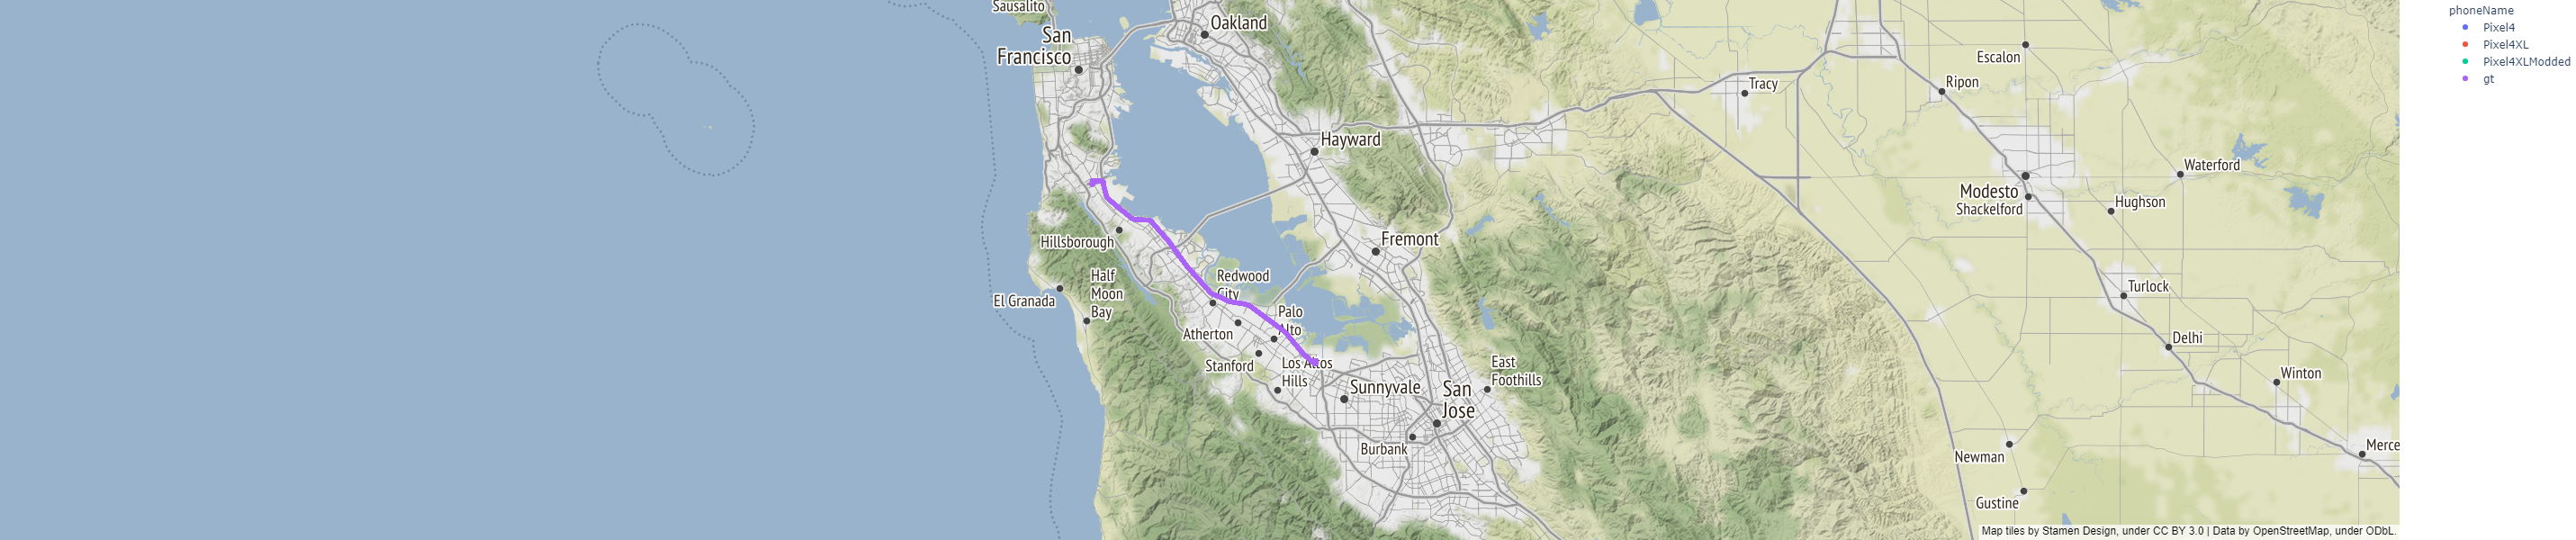

In [35]:
visualize_collection(train, collections[6])

In [75]:
train, test, sub, gt = get_data()
sp0_idx = train_sp0_pred[train_sp0_pred['isSpeed0']==1].index
train.loc[sp0_idx, ['latDeg', 'lngDeg']] = np.nan

In [85]:
# 連続区間のグルーピング
def section_grouping(df):
    null_idx = df[df['latDeg'].isnull()].index
    not_null_idx = df[~df['latDeg'].isnull()].index
    head_idx = df.groupby('phone').head(1).index
    prev_null_idx = df[df['latDeg'].shift(1).isnull()].index
    
    df['section'] = np.nan
    df.loc[list(set(not_null_idx) & set(prev_null_idx)), 'section'] = 1
    df.loc[list(set(not_null_idx) & set(head_idx)), 'section'] = 1
    df['section'] = df['section'].cumsum()
    df['section'] = df['section'].fillna(method='ffill')
    df.loc[null_idx,'section'] = np.nan    
    
    return df

In [86]:
train = section_grouping(train)

In [88]:
train.to_csv('check.csv')

In [93]:
train_org = train.copy()

# kalmanフィルタ

In [92]:
T = 1.0
state_transition = np.array([[1, 0, T, 0, 0.5 * T ** 2, 0], [0, 1, 0, T, 0, 0.5 * T ** 2], [0, 0, 1, 0, T, 0],
                             [0, 0, 0, 1, 0, T], [0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 1]])
process_noise = np.diag([1e-5, 1e-5, 5e-6, 5e-6, 1e-6, 1e-6]) + np.ones((6, 6)) * 1e-9
observation_model = np.array([[1, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0]])
observation_noise = np.diag([5e-5, 5e-5]) + np.ones((2, 2)) * 1e-9

kf = simdkalman.KalmanFilter(
        state_transition = state_transition,
        process_noise = process_noise,
        observation_model = observation_model,
        observation_noise = observation_noise)

def apply_kf_smoothing(df, kf_=kf):
    sections = df['section'].dropna().unique()
    for section in sections:
        idx = df[df['section']==section].index
        data = df.loc[idx, ['latDeg', 'lngDeg']].to_numpy()
        data = data.reshape(1, len(data), 2)
        smoothed = kf_.smooth(data)
        df.loc[idx, 'latDeg'] = smoothed.states.mean[0, :, 0]
        df.loc[idx, 'lngDeg'] = smoothed.states.mean[0, :, 1]
    return df

In [94]:
train = apply_kf_smoothing(train)

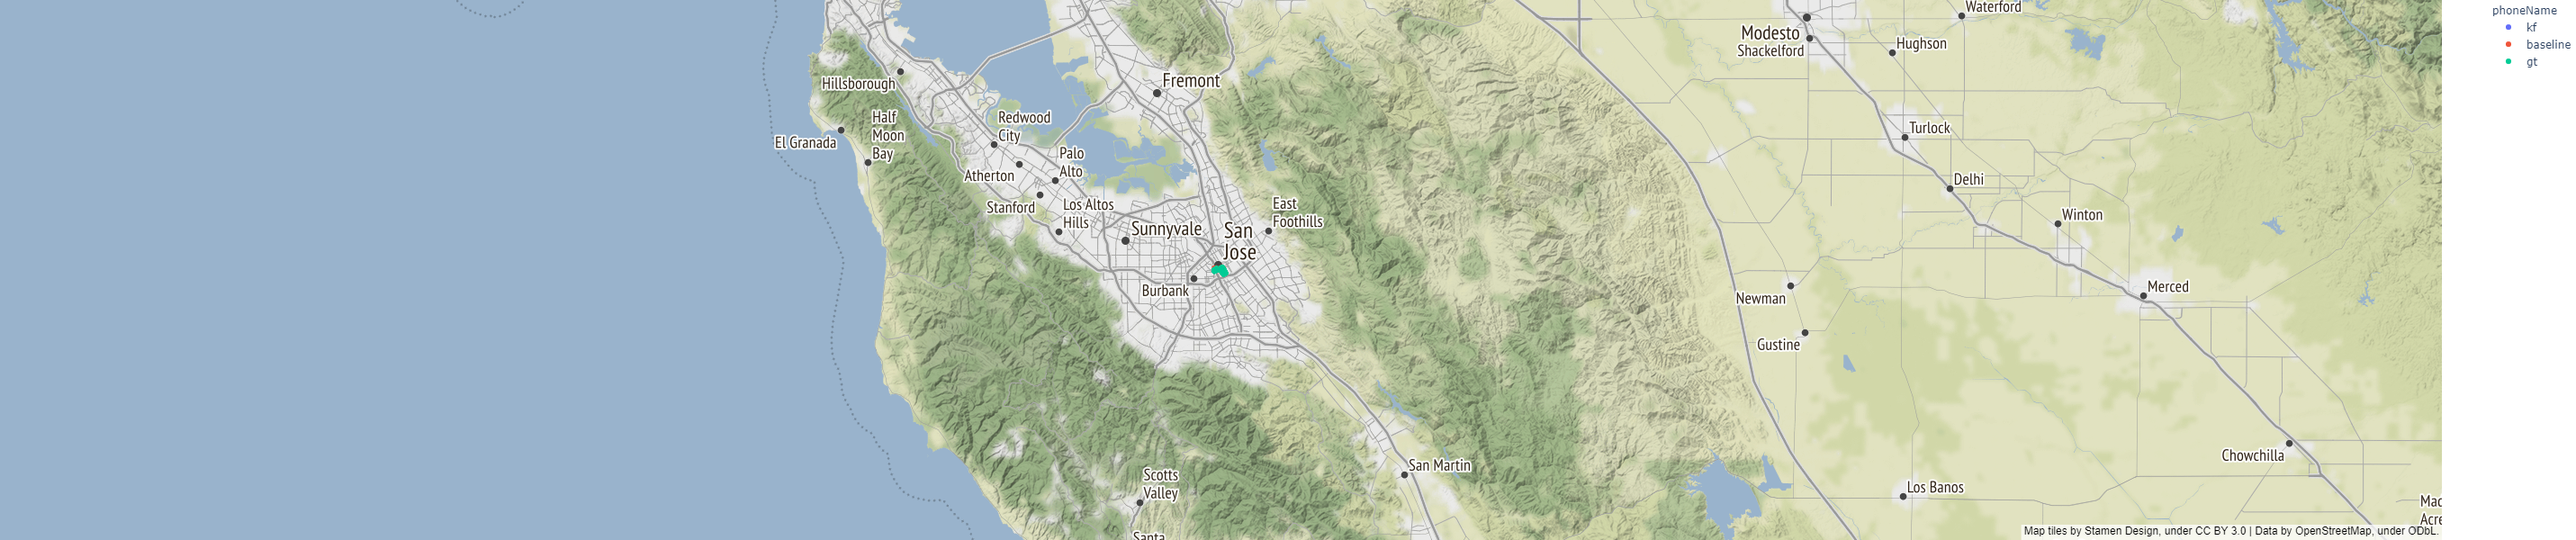

In [115]:
tmp1 = train.copy()
tmp2 = train_org.copy()
tmp3 = gt.copy()

tmp1['phoneName'] = 'kf'
tmp2['phoneName'] = 'baseline'
tmp3['phoneName'] = 'gt'

tmp = pd.concat([tmp1, tmp2, tmp3])

visualize_collection(tmp, collections[23])

In [117]:
df = pd.DataFrame()
df['g'] = ['a', 'a', 'a', 'a', 'b', 'b', 'b', 'b']
df['v'] = [1, np.nan, 2, np.nan, np.nan, 3, 4, np.nan]

In [118]:
df

g    v
0  a  1.0
1  a  NaN
2  a  2.0
3  a  NaN
4  b  NaN
5  b  3.0
6  b  4.0
7  b  NaN

In [121]:
df['bf'] = df.groupby('g')['v'].fillna(method='bfill')
df['ff'] = df.groupby('g')['v'].fillna(method='ffill')

In [125]:
df['f'] = df[['bf', 'ff']].mean(axis=1)

In [126]:
df

g    v   bf   ff    f
0  a  1.0  1.0  1.0  1.0
1  a  NaN  2.0  1.0  1.5
2  a  2.0  2.0  2.0  2.0
3  a  NaN  NaN  2.0  2.0
4  b  NaN  3.0  NaN  3.0
5  b  3.0  3.0  3.0  3.0
6  b  4.0  4.0  4.0  4.0
7  b  NaN  NaN  4.0  4.0

In [ ]:
df.groupby('g')['v'].fillna(method='ffill')

In [91]:
data = train.loc[train['section']==1, ['latDeg', 'lngDeg']].to_numpy()
data.reshape(1, len(data), 2)

array([[[  37.4235863, -122.0941344],
        [  37.4235859, -122.0941303],
        [  37.4235787, -122.0941309],
        ...,
        [  37.645833 , -122.4056143],
        [  37.645819 , -122.4056082],
        [  37.6458202, -122.4056141]]])

In [20]:
train = apply_kf_smoothing(train)
train.to_csv(OUTPUT + '/train_ro_rog_kf.csv', index=False)

# speed0の処理

In [21]:
def sp0_process(df, sp0_result):
    df = df.merge(sp0_result, on=['collectionName', 'phoneName', 'millisSinceGpsEpoch'], how='inner')
    df['phone'] = df['collectionName'] + '_' + df['phoneName']
    df['group'] = df.groupby('phone').cumcount()
    df.loc[(df['group']>0)&(df['isSpeed0']==1),'group'] = np.nan
    df['group'] = df['group'].fillna(method='ffill')
    df[['latDeg', 'lngDeg']] = df.groupby(['phone', 'group'])[['latDeg','lngDeg']].transform('mean')
    return df

In [22]:
train_sp0_pred = pd.read_csv('../output/prep/speed0_pred_v001/train_sp0_pred.csv')
train = sp0_process(train, train_sp0_pred)
train.to_csv(OUTPUT + '/train_ro_rog_kf_sp0.csv', index=False)

# phones_mean

In [23]:
def make_lerp_data(df):
    '''
    Generate interpolated lat,lng values for different phone times in the same collection.
    '''
    org_columns = df.columns
    
    # Generate a combination of time x collection x phone and combine it with the original data (generate records to be interpolated)
    time_list = df[['collectionName', 'millisSinceGpsEpoch']].drop_duplicates()
    phone_list =df[['collectionName', 'phoneName']].drop_duplicates()
    tmp = time_list.merge(phone_list, on='collectionName', how='outer')
    
    lerp_df = tmp.merge(df, on=['collectionName', 'millisSinceGpsEpoch', 'phoneName'], how='left')
    lerp_df['phone'] = lerp_df['collectionName'] + '_' + lerp_df['phoneName']
    lerp_df = lerp_df.sort_values(['phone', 'millisSinceGpsEpoch'])
    
    # linear interpolation
    lerp_df['latDeg_prev'] = lerp_df['latDeg'].shift(1)
    lerp_df['latDeg_next'] = lerp_df['latDeg'].shift(-1)
    lerp_df['lngDeg_prev'] = lerp_df['lngDeg'].shift(1)
    lerp_df['lngDeg_next'] = lerp_df['lngDeg'].shift(-1)
    lerp_df['phone_prev'] = lerp_df['phone'].shift(1)
    lerp_df['phone_next'] = lerp_df['phone'].shift(-1)
    lerp_df['time_prev'] = lerp_df['millisSinceGpsEpoch'].shift(1)
    lerp_df['time_next'] = lerp_df['millisSinceGpsEpoch'].shift(-1)
    # Leave only records to be interpolated
    lerp_df = lerp_df[(lerp_df['latDeg'].isnull())&(lerp_df['phone']==lerp_df['phone_prev'])&(lerp_df['phone']==lerp_df['phone_next'])].copy()
    # calc lerp
    lerp_df['latDeg'] = lerp_df['latDeg_prev'] + ((lerp_df['latDeg_next'] - lerp_df['latDeg_prev']) * ((lerp_df['millisSinceGpsEpoch'] - lerp_df['time_prev']) / (lerp_df['time_next'] - lerp_df['time_prev']))) 
    lerp_df['lngDeg'] = lerp_df['lngDeg_prev'] + ((lerp_df['lngDeg_next'] - lerp_df['lngDeg_prev']) * ((lerp_df['millisSinceGpsEpoch'] - lerp_df['time_prev']) / (lerp_df['time_next'] - lerp_df['time_prev']))) 
    
    # Leave only the data that has a complete set of previous and next data.
    lerp_df = lerp_df[~lerp_df['latDeg'].isnull()]
    
    return lerp_df[org_columns]

def calc_mean_pred(df, lerp_df):
    '''
    Make a prediction based on the average of the predictions of phones in the same collection.
    '''
    add_lerp = pd.concat([df, lerp_df])
    mean_pred_result = add_lerp.groupby(['collectionName', 'millisSinceGpsEpoch'])[['latDeg', 'lngDeg']].mean().reset_index()
    mean_pred_df = df[['collectionName', 'phoneName', 'millisSinceGpsEpoch']].copy()
    mean_pred_df = mean_pred_df.merge(mean_pred_result[['collectionName', 'millisSinceGpsEpoch', 'latDeg', 'lngDeg']], on=['collectionName', 'millisSinceGpsEpoch'], how='left')
    return mean_pred_df

In [24]:
train_lerp = make_lerp_data(train)
train = calc_mean_pred(train, train_lerp)
train.to_csv(OUTPUT + '/train_ro_rog_kf_sp0_pm.csv', index=False)

# position_shift

In [25]:
train['phone'] = train['collectionName'] + '_' + train['phoneName']

In [26]:
def WGS84_to_ECEF(lat, lon, alt):
    # convert to radians
    rad_lat = lat * (np.pi / 180.0)
    rad_lon = lon * (np.pi / 180.0)
    a    = 6378137.0
    # f is the flattening factor
    finv = 298.257223563
    f = 1 / finv   
    # e is the eccentricity
    e2 = 1 - (1 - f) * (1 - f)    
    # N is the radius of curvature in the prime vertical
    N = a / np.sqrt(1 - e2 * np.sin(rad_lat) * np.sin(rad_lat))
    x = (N + alt) * np.cos(rad_lat) * np.cos(rad_lon)
    y = (N + alt) * np.cos(rad_lat) * np.sin(rad_lon)
    z = (N * (1 - e2) + alt)        * np.sin(rad_lat)
    return x, y, z

transformer = pyproj.Transformer.from_crs(
    {"proj":'geocent', "ellps":'WGS84', "datum":'WGS84'},
    {"proj":'latlong', "ellps":'WGS84', "datum":'WGS84'},)

def ECEF_to_WGS84(x,y,z):
    lon, lat, alt = transformer.transform(x,y,z,radians=False)
    return lon, lat, alt
msge = 'millisSinceGpsEpoch'

In [27]:
def position_shift(df,a):

    d = df.copy()
    d['heightAboveWgs84EllipsoidM'] = 63.5
    d['x'], d['y'], d['z'] = zip(*d.apply(lambda x: WGS84_to_ECEF(x.latDeg, x.lngDeg, x.heightAboveWgs84EllipsoidM), axis=1))

    #a = -0.2
    d.sort_values(['phone', msge], inplace=True)
    for fi in ['x','y','z']:
        d[[fi+'p']] = d[fi].shift().where(d['phone'].eq(d['phone'].shift()))
        d[[fi+'diff']] = d[fi]-d[fi+'p']
    #d[['yp']] = d['y'].shift().where(d['phone'].eq(d['phone'].shift()))
    d[['dist']] = np.sqrt(d['xdiff']**2 + d['ydiff']**2+ d['zdiff']**2)
    for fi in ['x','y','z']:
        d[[fi+'new']] = d[fi+'p'] + d[fi+'diff']*(1-a/d['dist'])
    lng, lat, alt = ECEF_to_WGS84(d['xnew'].values,d['ynew'].values,d['znew'].values)
    
    lng[np.isnan(lng)] = d.loc[np.isnan(lng),'lngDeg']
    lat[np.isnan(lat)] = d.loc[np.isnan(lat),'latDeg']
    d['latDeg'] = lat
    d['lngDeg'] = lng
    
    return d 

def objective(trial):
    a = trial.suggest_uniform('a', -1, 1)
    score = get_train_score(position_shift(train, a),gt)
    return score

In [28]:
study = optuna.create_study()
study.optimize(objective, n_trials=30)
opt_a = study.best_params['a']
print(opt_a)

[I 2021-06-20 15:24:02,137] A new study created in memory with name: no-name-7de55850-a248-4fad-b4ba-f7639e74623b
[I 2021-06-20 15:24:05,793] Trial 0 finished with value: 3.304354896826572 and parameters: {'a': 0.7741303893284568}. Best is trial 0 with value: 3.304354896826572.
[I 2021-06-20 15:24:09,526] Trial 1 finished with value: 3.3983803196515354 and parameters: {'a': -0.13773004654979903}. Best is trial 0 with value: 3.304354896826572.
[I 2021-06-20 15:24:13,257] Trial 2 finished with value: 3.400334295606921 and parameters: {'a': -0.1443053298597341}. Best is trial 0 with value: 3.304354896826572.
[I 2021-06-20 15:24:16,963] Trial 3 finished with value: 3.406218555037516 and parameters: {'a': -0.16515985952107481}. Best is trial 0 with value: 3.304354896826572.
[I 2021-06-20 15:24:20,629] Trial 4 finished with value: 3.3029025173064075 and parameters: {'a': 0.34751228749676843}. Best is trial 4 with value: 3.3029025173064075.
[I 2021-06-20 15:24:24,323] Trial 5 finished with va

0.5300802069684979


In [29]:
train = position_shift(train, opt_a)
train.to_csv(OUTPUT + '/train_ro_rog_kf_sp0_pm_ps.csv', index=False)

# trainの結果確認

In [30]:
for f in ['train_ro_rog_kf', 'train_ro_rog_kf_sp0', 'train_ro_rog_kf_sp0_pm', 'train_ro_rog_kf_sp0_pm_ps']:
    print(f, get_train_score(pd.read_csv(OUTPUT + '/' + f + '.csv'), gt))

train_ro_rog_kf 3.839553534776271
train_ro_rog_kf_sp0 3.5853108302665273
train_ro_rog_kf_sp0_pm 3.3634355671822225
train_ro_rog_kf_sp0_pm_ps 3.2930584887106034


In [31]:
result = train_result(train)

In [32]:
result.err

percentile50  percentile95  p50_p90_mean
phone                                                                        
2020-05-14-US-MTV-1_Pixel4               1.166238      2.325088      1.745663
2020-05-14-US-MTV-1_Pixel4XLModded       1.054149      2.189631      1.621890
2020-05-14-US-MTV-2_Pixel4               1.693334      3.079620      2.386477
2020-05-14-US-MTV-2_Pixel4XLModded       1.796020      4.586583      3.191301
2020-05-21-US-MTV-1_Pixel4               1.763168      3.154850      2.459009
2020-05-21-US-MTV-2_Pixel4               0.642522      2.257180      1.449851
2020-05-21-US-MTV-2_Pixel4XL             0.599709      2.149450      1.374579
2020-05-29-US-MTV-1_Pixel4               2.062202      3.483253      2.772727
2020-05-29-US-MTV-1_Pixel4XL             1.842217      3.091435      2.466826
2020-05-29-US-MTV-1_Pixel4XLModded       1.696410      3.192019      2.444214
2020-05-29-US-MTV-2_Pixel4               2.242769      3.460270      2.851519
2020-05-29-US-MTV-2_Pixel4XL             2.169535      3.489208      2.829371
2020-06-04-US-MTV-1_Pixel4               1.256024      2.555914      1.905969
2020-06-04-US-MTV-1_Pixel4XL             0.750488      2.228822      1.489655
2020-06-04-US-MTV-1_Pixel4XLModded       1.601064      2.738890      2.169977
2020-06-05-US-MTV-1_Pixel4               1.174936      2.388693      1.781814
2020-06-05-US-MTV-1_Pixel4XL             1.227762      2.475370      1.851566
2020-06-05-US-MTV-1_Pixel4XLModded       1.027739      2.124507      1.576123
2020-06-05-US-MTV-2_Pixel4               0.930297      2.527999      1.729148
2020-06-05-US-MTV-2_Pixel4XL             0.881298      2.437316      1.659307
2020-06-11-US-MTV-1_Pixel4               0.966399      1.899900      1.433150
2020-06-11-US-MTV-1_Pixel4XL             1.019845      1.973155      1.496500
2020-07-08-US-MTV-1_Pixel4               1.359156      2.561886      1.960521
2020-07-08-US-MTV-1_Pixel4XL             1.185829      2.278060      1.731945
2020-07-08-US-MTV-1_Pixel4XLModded       0.860558      2.475207      1.667882
2020-07-17-US-MTV-1_Mi8                  1.722366      3.438405      2.580386
2020-07-17-US-MTV-2_Mi8                  2.876536      4.234787      3.555662
2020-08-03-US-MTV-1_Mi8                  1.661337      2.784708      2.223023
2020-08-03-US-MTV-1_Pixel4               1.786363      2.959554      2.372959
2020-08-06-US-MTV-2_Mi8                  1.727191      2.910650      2.318921
2020-08-06-US-MTV-2_Pixel4               1.125971      2.102345      1.614158
2020-08-06-US-MTV-2_Pixel4XL             1.045816      2.714181      1.879999
2020-09-04-US-SF-1_Mi8                   2.054097      3.574918      2.814507
2020-09-04-US-SF-1_Pixel4                1.848234     10.908831      6.378533
2020-09-04-US-SF-1_Pixel4XL              1.287214      2.509962      1.898588
2020-09-04-US-SF-2_Mi8                   1.597900      4.720774      3.159337
2020-09-04-US-SF-2_Pixel4                1.164885      3.545121      2.355003
2020-09-04-US-SF-2_Pixel4XL              0.825927      3.930991      2.378459
2021-01-04-US-RWC-1_Pixel4               1.050107      2.599019      1.824563
2021-01-04-US-RWC-1_Pixel4Modded         1.827100      3.768618      2.797859
2021-01-04-US-RWC-1_Pixel4XL             1.877618      5.227773      3.552696
2021-01-04-US-RWC-1_Pixel5               1.203424      2.723725      1.963574
2021-01-04-US-RWC-2_Pixel4               1.746887      2.989511      2.368199
2021-01-04-US-RWC-2_Pixel4Modded         2.018233      4.495885      3.257059
2021-01-04-US-RWC-2_Pixel4XL             2.306105      6.229923      4.268014
2021-01-04-US-RWC-2_Pixel5               1.634502      3.657280      2.645891
2021-01-05-US-SVL-1_Mi8                  1.365257      3.048146      2.206702
2021-01-05-US-SVL-1_Pixel4               1.050317      3.777927      2.414122
2021-01-05-US-SVL-1_Pixel4XL             2.574538      5.732128      4.153333
2021-01-05-US-SVL-1_Pixel5               3.118649      6.81

# make_sub

In [33]:
test = pd.read_csv(INPUT + '/' + 'baseline_locations_test.csv')

In [34]:
test = add_distance_diff(test)
test.loc[((test['dist_prev'] > ro_th) & (test['dist_next'] > ro_th)), ['latDeg', 'lngDeg']] = np.nan

In [35]:
rog_df = test[test['collectionName'].isin(rog_target)].copy()
rog_gt = gt[gt['collectionName'].isin(rog_target)].copy()
rog_df = remove_based_on_gt(rog_df, rog_gt, rog_th)
rog_df.to_csv(OUTPUT + '/test_rog.csv', index=False)
rog_df = interpolate_remove_point(rog_df)
test.loc[rog_df.index, ['latDeg', 'lngDeg']] = rog_df[['latDeg', 'lngDeg']]

In [36]:
test = apply_kf_smoothing(test)

In [37]:
test_sp0_pred = pd.read_csv('../output/prep/speed0_pred_v001/test_sp0_pred.csv')
test = sp0_process(test, test_sp0_pred)

In [38]:
test_lerp = make_lerp_data(test)
test = calc_mean_pred(test, test_lerp)

In [39]:
test['phone'] = test['collectionName'] + '_' + test['phoneName']

In [40]:
test = position_shift(test, opt_a)

In [41]:
assert len(test) == len(sub)

In [42]:
sub['latDeg'] = test['latDeg']
sub['lngDeg'] = test['lngDeg']
sub.to_csv(OUTPUT + f'/{nb_name}_submission.csv', index=False)